In [1]:
# data manipulation
from jetstream.bigquery_client import BigQueryClient
import numpy as np
import pandas as pd
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
#stats
from statsmodels.stats.proportion import proportion_confint
from sklearn.neighbors import KernelDensity
from scipy.stats import binom, norm, kstest
#misc
from tqdm import tqdm
import pickle as pkl

In [2]:
cache_path = 'simulation_dfs_2.pkl'

In [3]:
def sign(a):
    return (a > 0) - (a < 0)

In [4]:
def CI_to_Pvalue(point: float, lower: float, upper: float, point_null: float = 0.0) -> float:
    '''
    Converts a confidence interval for difference into a 2-sided p-value, 
    assuming large sample normal approximation for the CI
    '''
    if np.isclose(upper, lower):
        return np.nan
    standard_error = (upper - lower)/(2*1.96)
    z_score = (np.abs(point) - point_null)/standard_error
    return (1-norm.cdf(z_score))*2

In [5]:
USE_CACHE = True

In [6]:
if not USE_CACHE:
    dfs = dict()
    for simulation_iteration in tqdm(range(100)): 
        dataset = 'dberry_simulated_AA_tests_{:02d}'.format(simulation_iteration)
        client = BigQueryClient(project='moz-fx-data-experiments',dataset=dataset)
        try:
            sim_results_df = client.table_to_dataframe('statistics_more_from_mozilla_96_overall_1')
        except Exception:
            print(f'Dataset {dataset} not found!')
            continue
        if sim_results_df.shape[0] == 0:
            print(f'Simulation {simulation_iteration} empty!')
            continue
        comparisons_df = sim_results_df.loc[~sim_results_df.comparison.isnull()].copy()
        comparisons_df.loc[:, 'different_signs'] = (comparisons_df.lower.apply(sign) != comparisons_df.upper.apply(sign))
        comparisons_df.loc[:, 'both_zero'] = np.isclose(comparisons_df.lower.apply(sign) & comparisons_df.upper.apply(sign), 0)
        comparisons_df.loc[:, 'CI_contains_zero'] = comparisons_df[['different_signs', 'both_zero']].apply(
            lambda row: 'Yes' if row.different_signs else ('Both-zero' if row.both_zero else 'No'), 
            axis = 'columns'
        )
    
        dfs[simulation_iteration] = comparisons_df

    with open(cache_path, 'wb') as f:
        pkl.dump(dfs, f)
else:
    with open(cache_path, 'rb') as f:
        dfs = pkl.load(f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:05<00:00,  4.25s/it]


In [7]:
with open(cache_path, 'rb') as f:
    df2s = pkl.load(f)

In [8]:
slug_cols = ['metric', 'statistic', 'parameter', 'branch', 'comparison', 'comparison_to_branch']

In [9]:
for i, df in dfs.items():
    df.loc[:, 'sim_number'] = i
    df.loc[:, 'result_slug'] = df.apply(lambda row: ':'.join(map(str, row[slug_cols])), axis = 'columns')
    df.loc[:, 'p-value'] = df.apply(lambda row: CI_to_Pvalue(row['point'], row['lower'], row['upper']), axis = 'columns')

# Analysis of p-value distributions

In [132]:
aggregate_df = pd.concat([df[[*slug_cols, 'result_slug', 'sim_number', 'p-value']] for df in dfs.values()])

In [136]:
results_pivot = aggregate_df.pivot(index=[*slug_cols, 'result_slug'], columns='sim_number')
sim_cols = ['sim_{:02d}'.format(i) for i in results_pivot.columns.droplevel(0)]
results_pivot.columns = sim_cols
results_pivot = results_pivot.reset_index()

In [137]:
results_no_NAs = results_pivot.loc[results_pivot[sim_cols].isna().mean(axis=1) == 0].copy()

In [138]:
results_no_NAs.loc[:, 'ks_test_pvalue'] = results_no_NAs.apply(lambda row: kstest(list(row[sim_cols]), 'uniform').pvalue, axis = 'columns')

# Aggregate Results

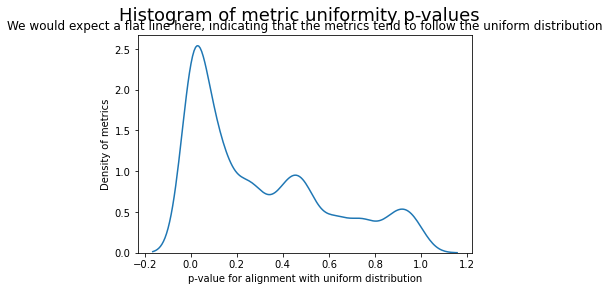

In [139]:
sns.kdeplot(results_no_NAs.ks_test_pvalue, bw_adjust=0.5)
plt.xlabel('p-value for alignment with uniform distribution')
plt.ylabel('Density of metrics')
plt.suptitle('Histogram of metric uniformity p-values', fontsize=18)
plt.title('We would expect a flat line here, indicating that the metrics tend to follow the uniform distribution')
plt.show()

In [140]:
# Test for all metrics following uniform distribution is rejected, more metrics are rejected than expected

In [141]:
kstest(list(results_no_NAs.ks_test_pvalue), 'uniform')

KstestResult(statistic=0.3175155121155132, pvalue=7.655802219863679e-15)

In [142]:
(
    results_no_NAs
    .loc[results_no_NAs.ks_test_pvalue < 0.05]
    .sort_values('ks_test_pvalue')
    .drop(columns = sim_cols)
    .to_csv('metric_kstest_pvalues.csv', index = False)
)

In [143]:
# would expect this to be .95 if everything calibrated properly
(results_no_NAs.ks_test_pvalue > 0.05).mean()

0.7125

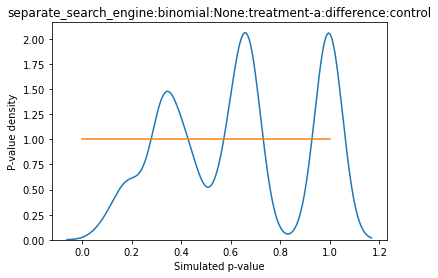

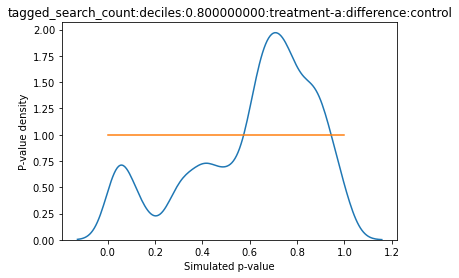

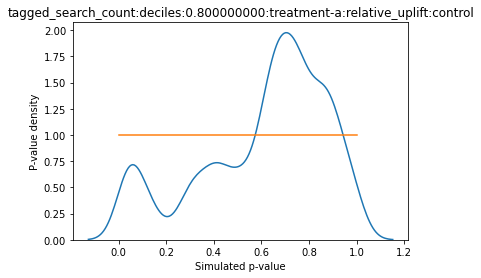

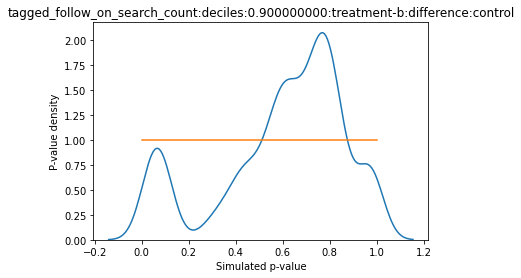

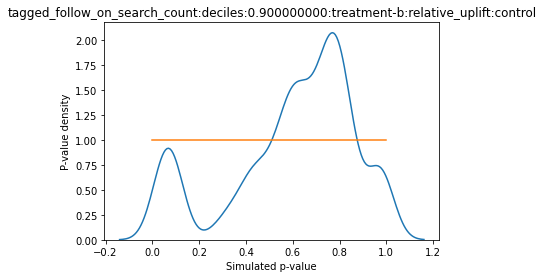

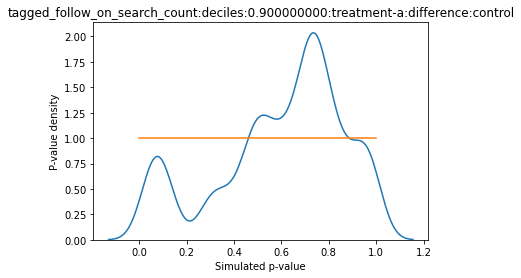

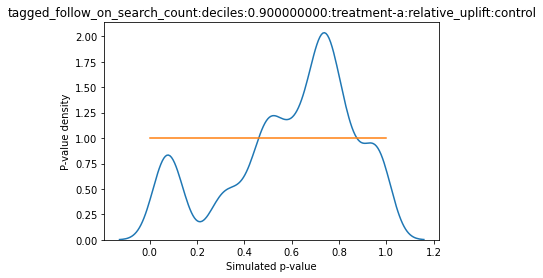

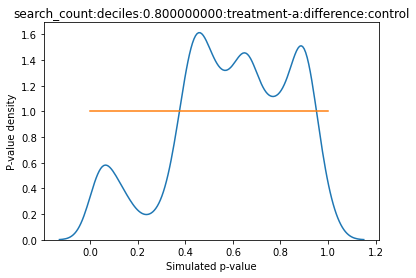

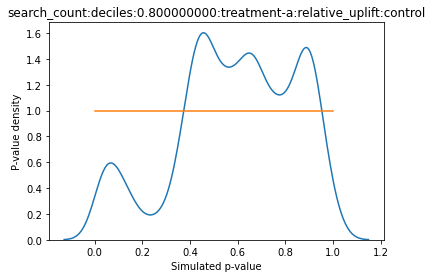

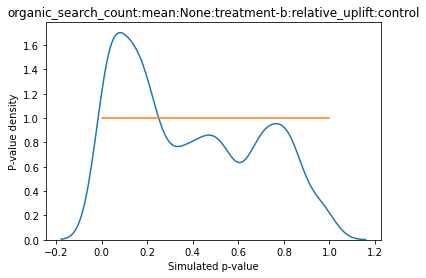

In [148]:
for _, row in results_no_NAs.sort_values('ks_test_pvalue').head(10).iterrows():
    sns.kdeplot(row[sim_cols], bw_adjust=0.5)
    sns.lineplot(x=[0,1],y=[1,1])
    plt.title(row['result_slug'])
    plt.xlabel('Simulated p-value')
    plt.ylabel('P-value density')
    plt.show()

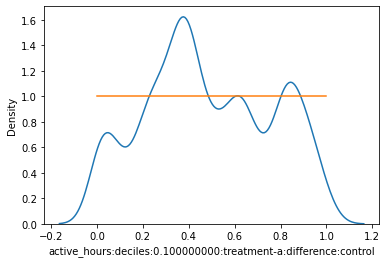

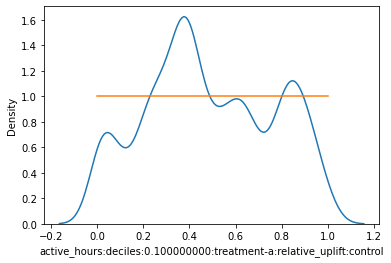

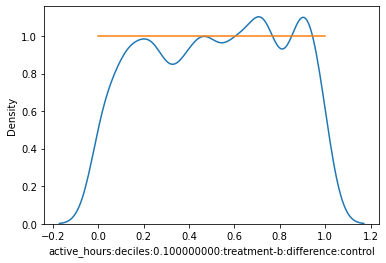

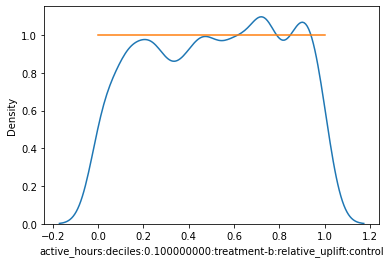

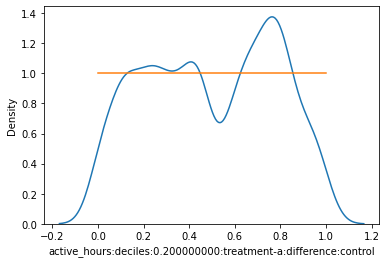

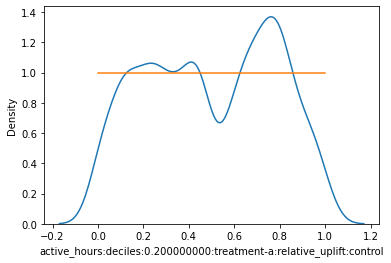

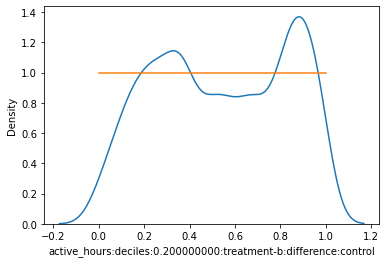

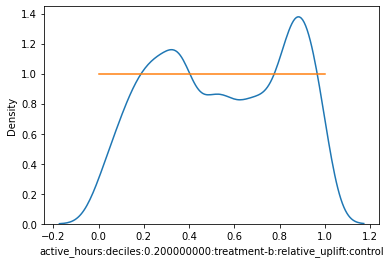

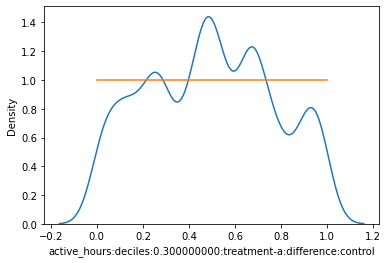

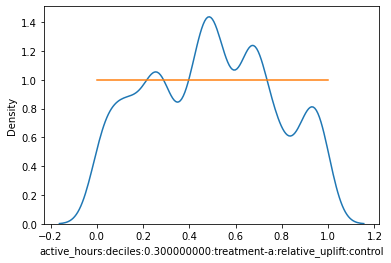

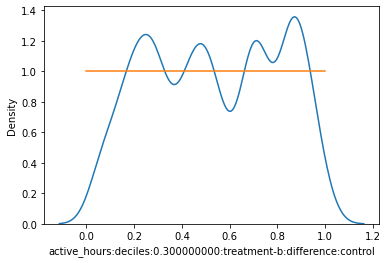

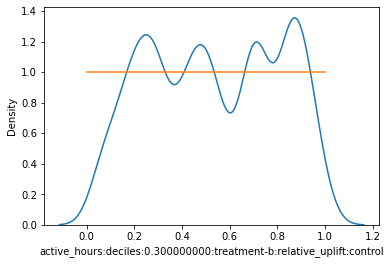

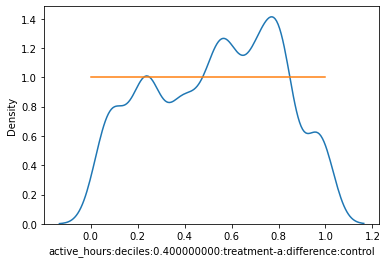

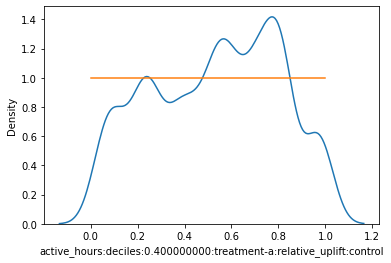

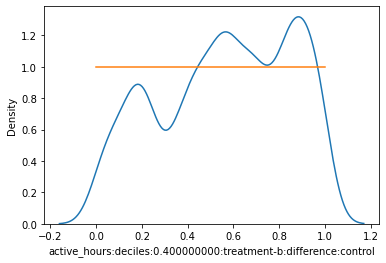

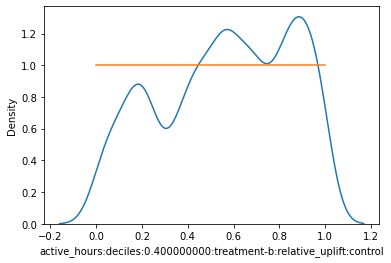

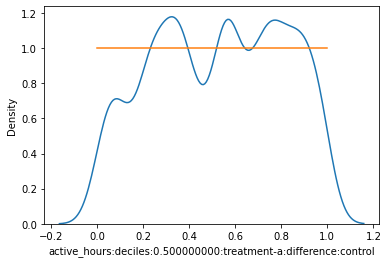

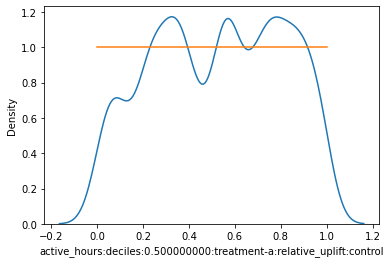

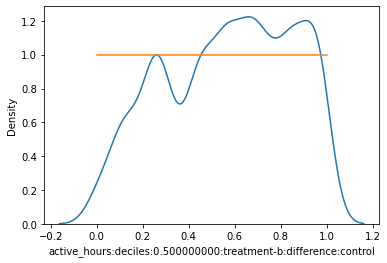

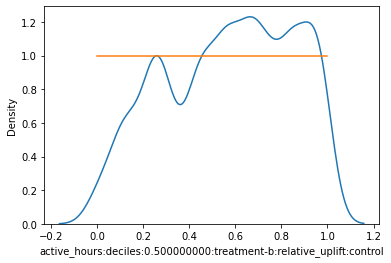

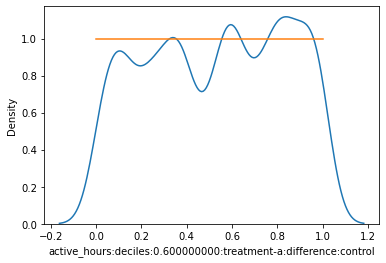

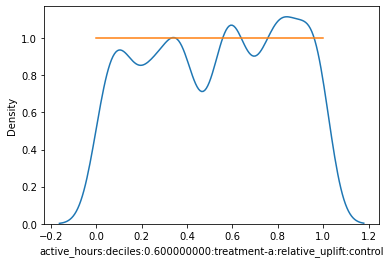

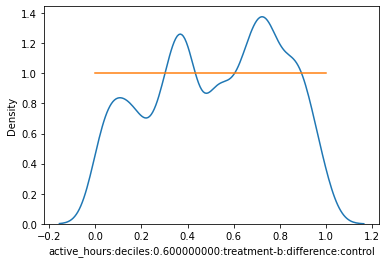

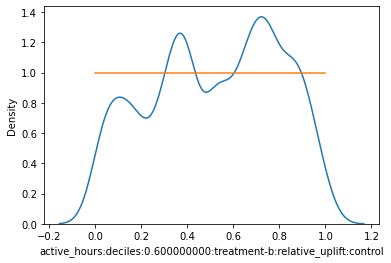

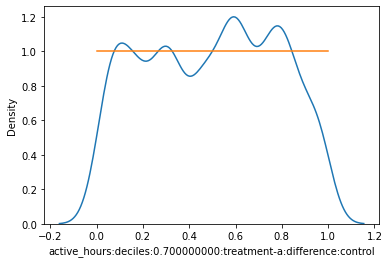

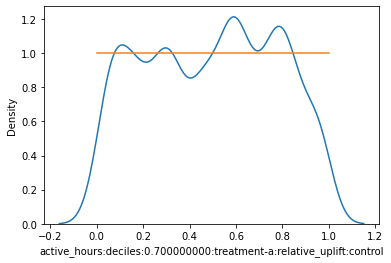

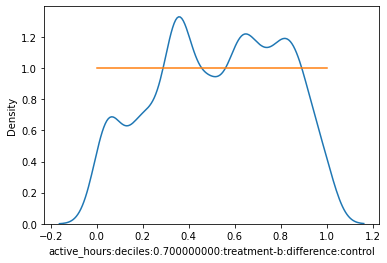

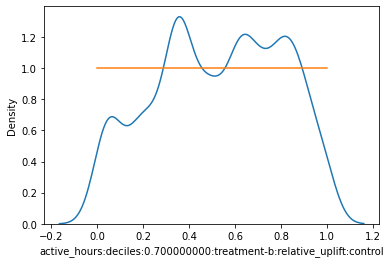

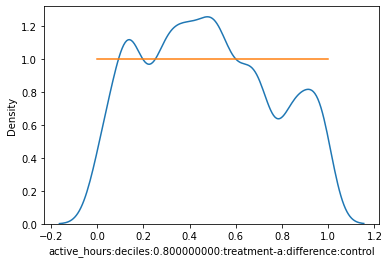

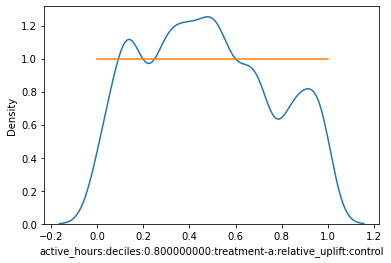

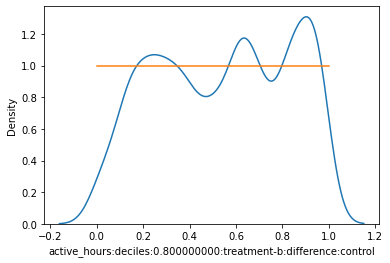

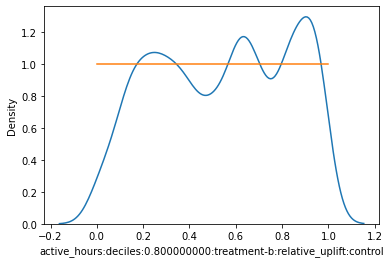

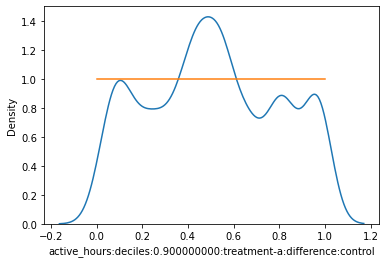

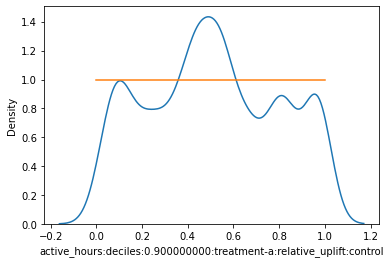

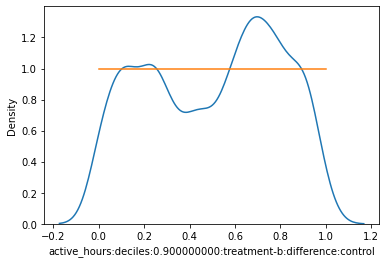

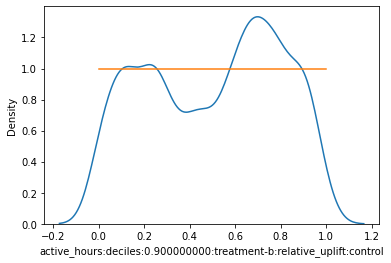

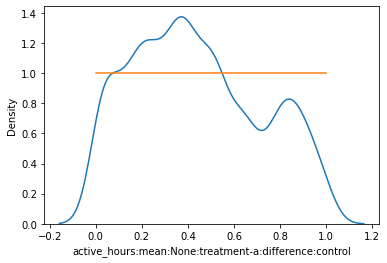

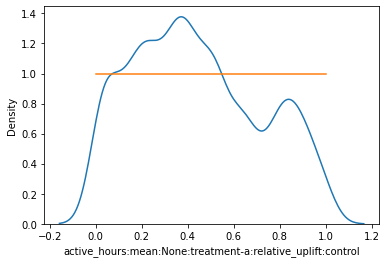

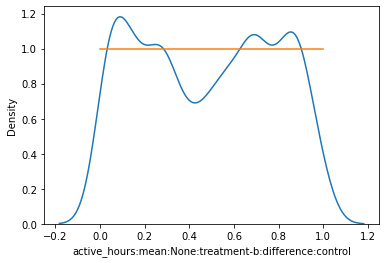

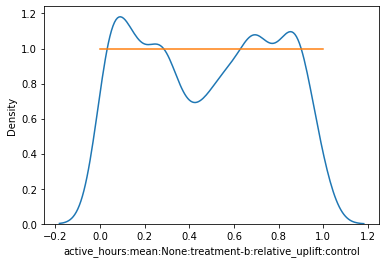

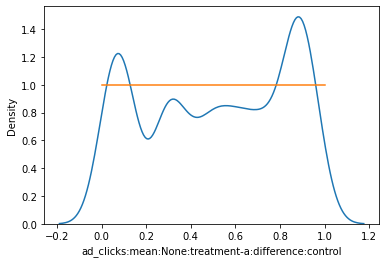

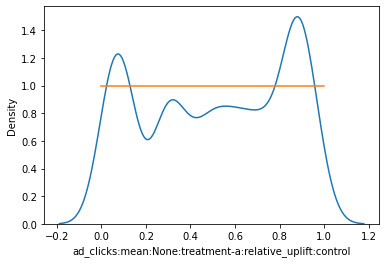

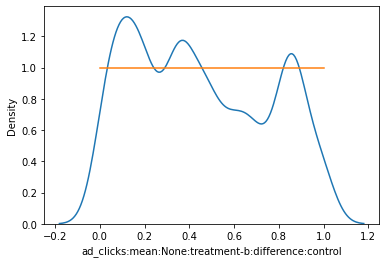

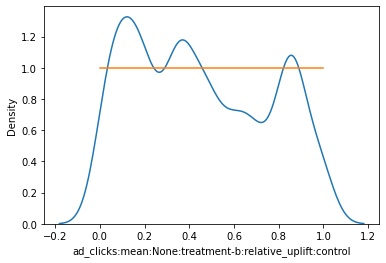

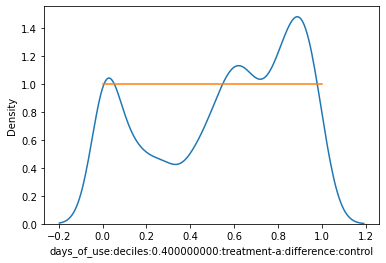

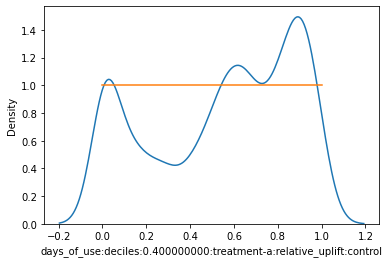

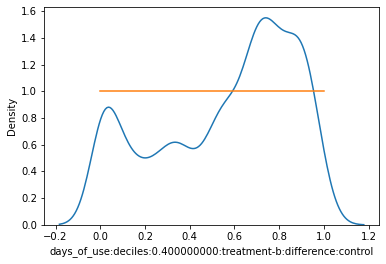

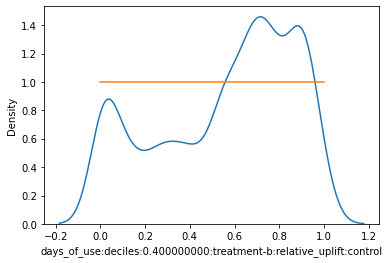

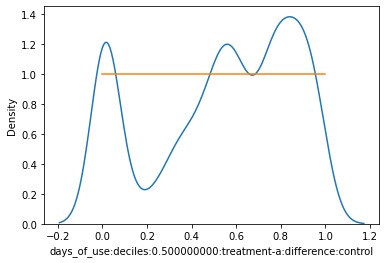

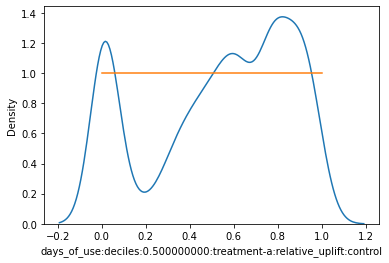

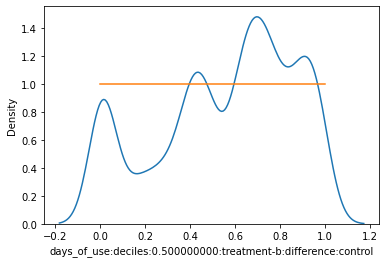

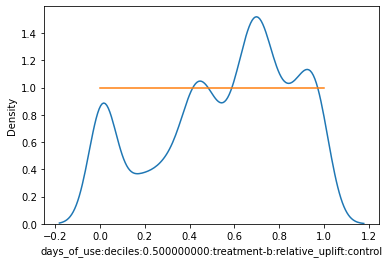

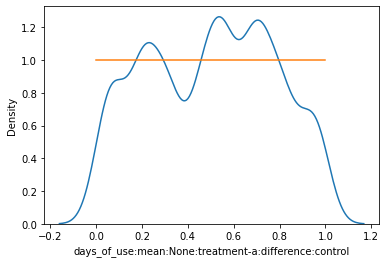

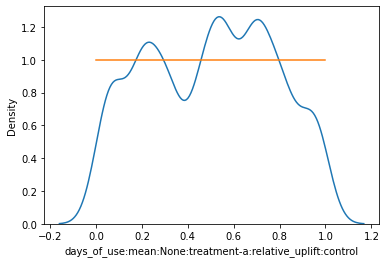

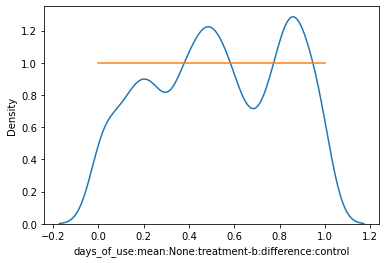

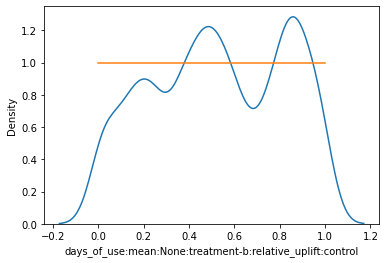

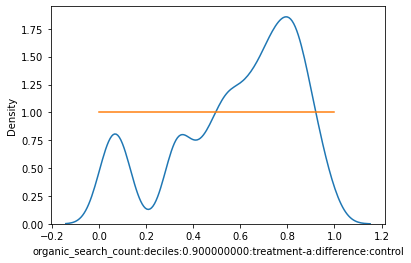

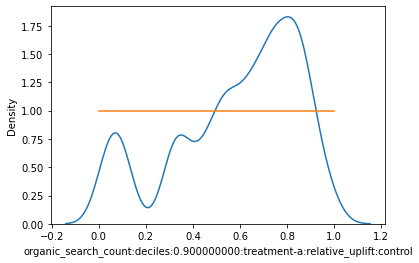

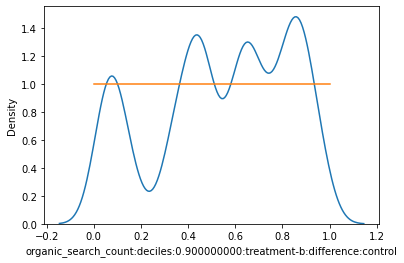

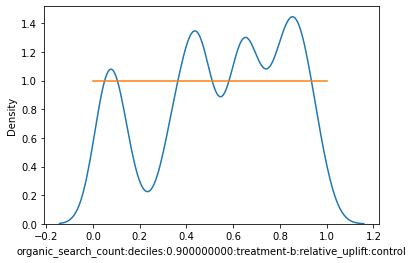

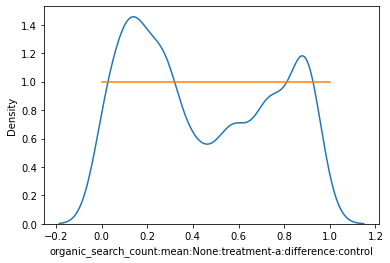

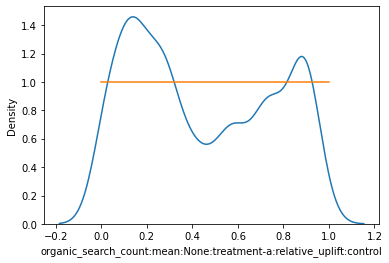

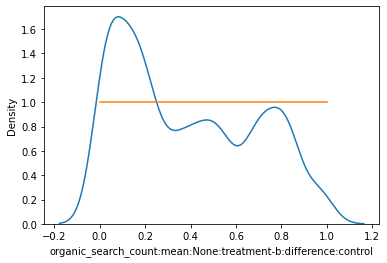

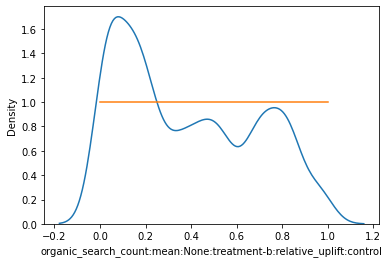

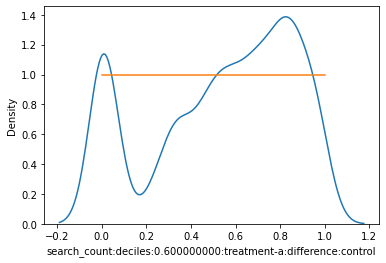

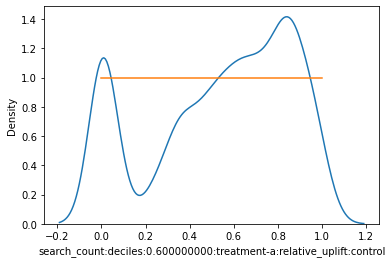

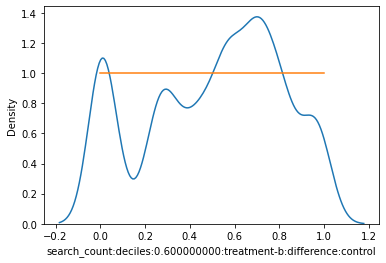

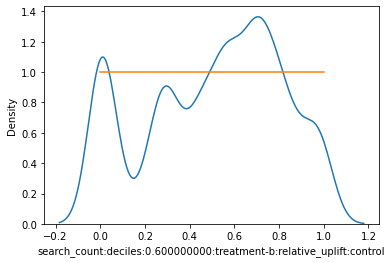

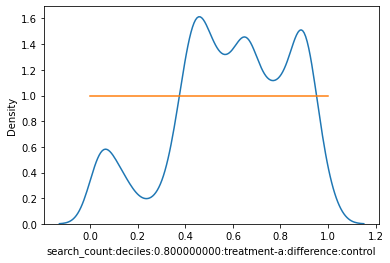

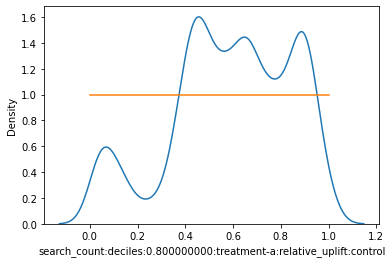

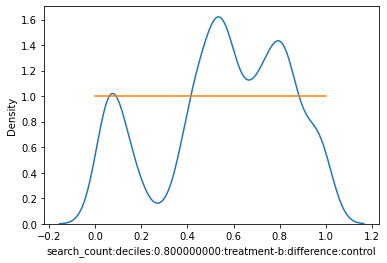

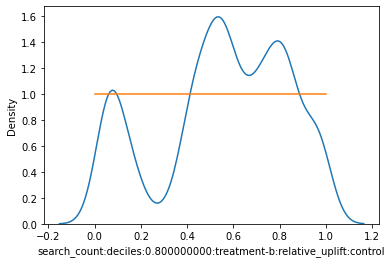

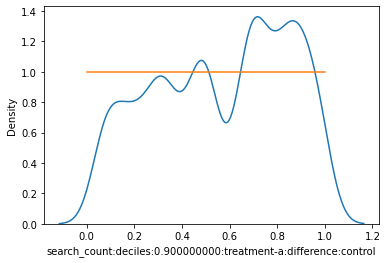

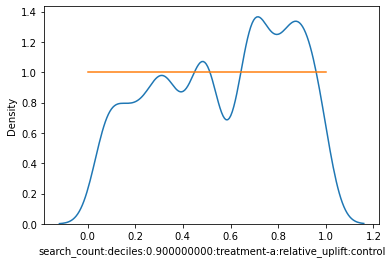

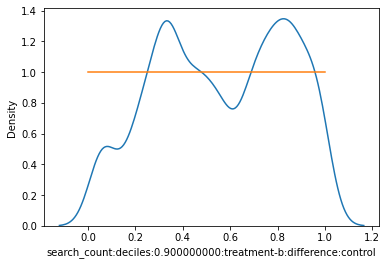

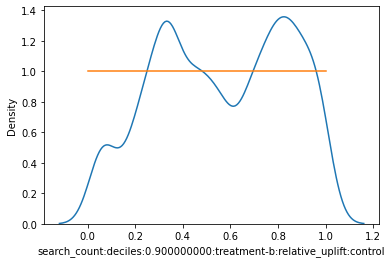

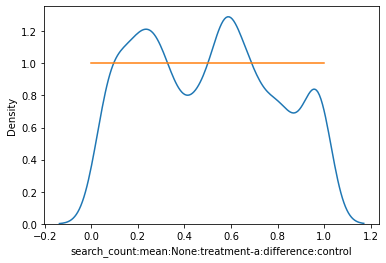

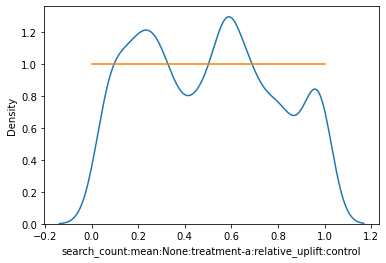

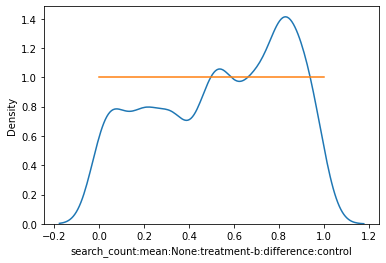

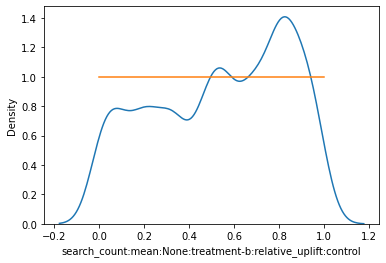

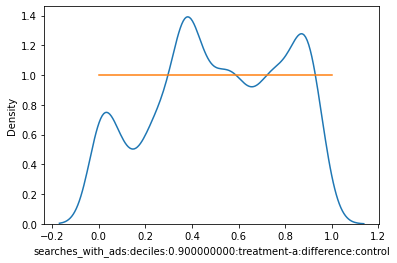

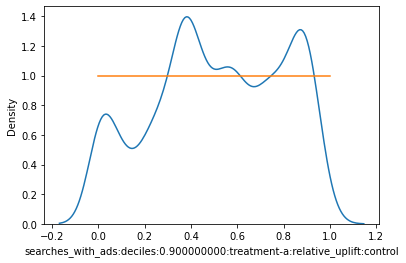

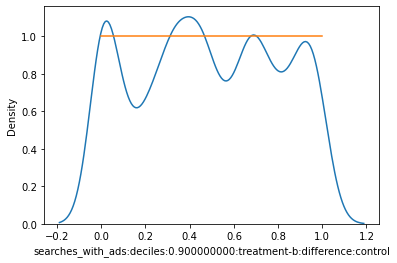

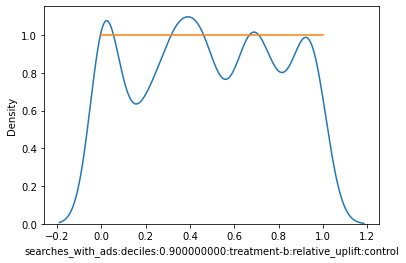

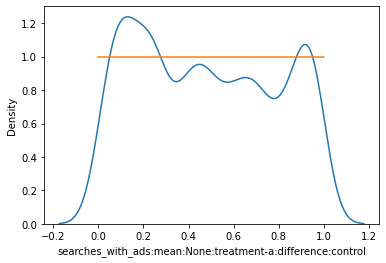

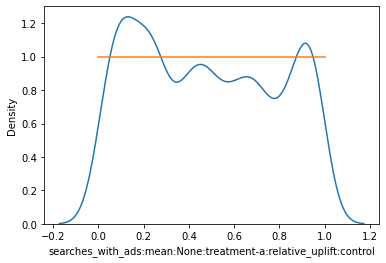

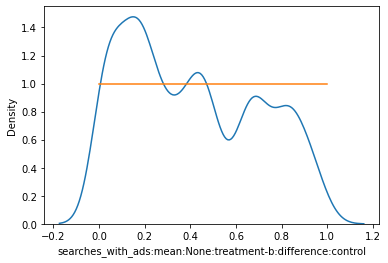

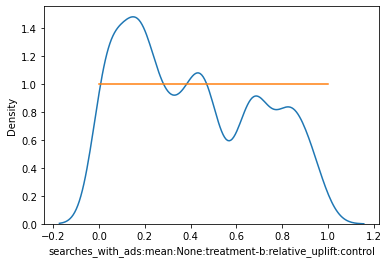

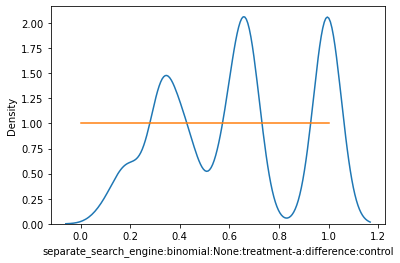

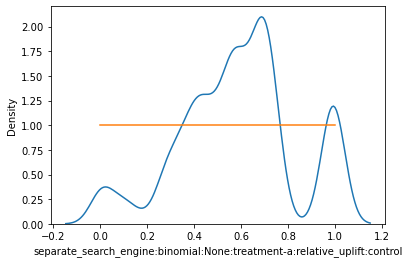

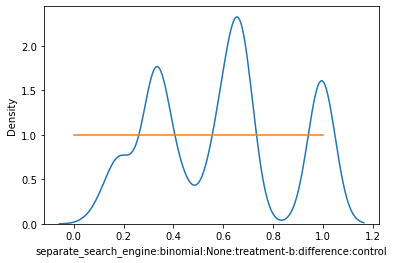

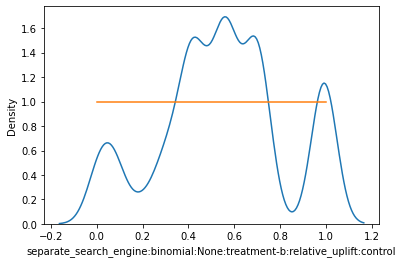

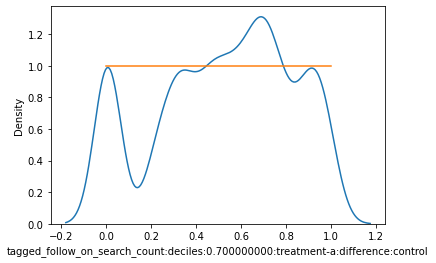

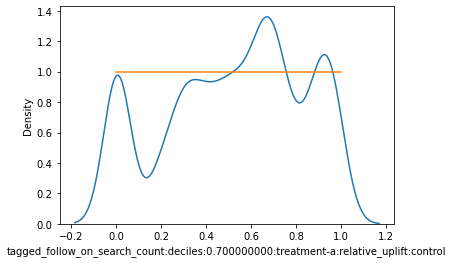

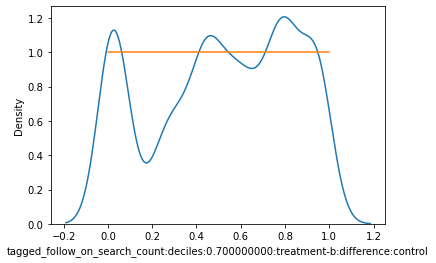

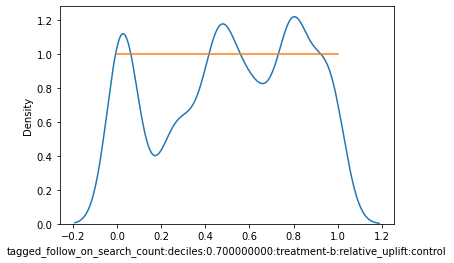

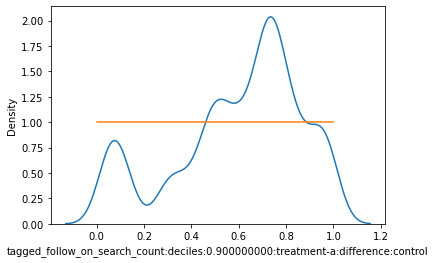

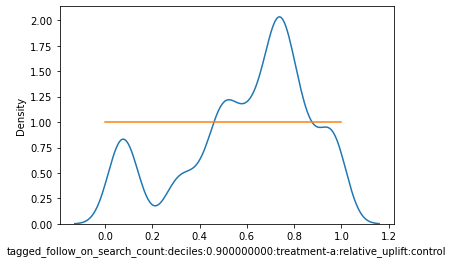

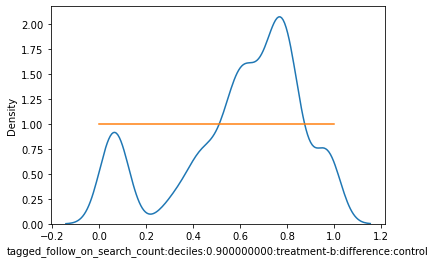

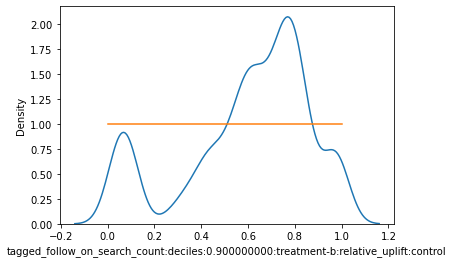

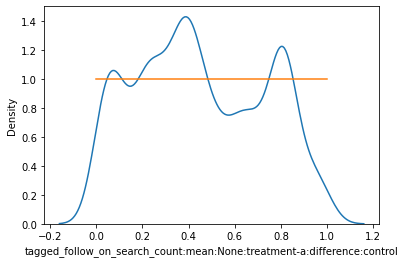

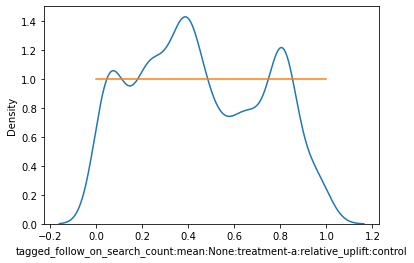

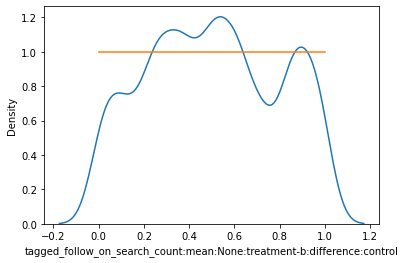

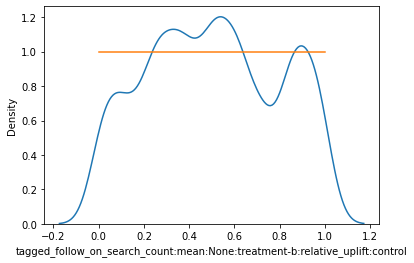

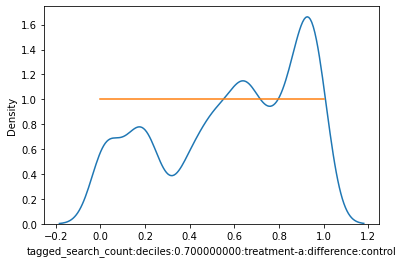

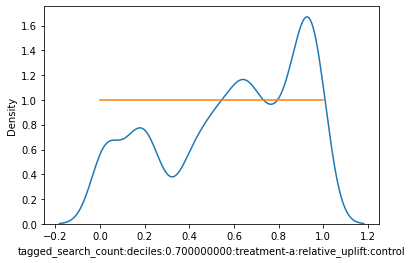

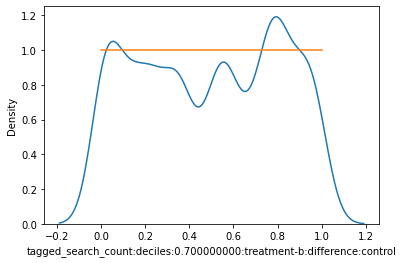

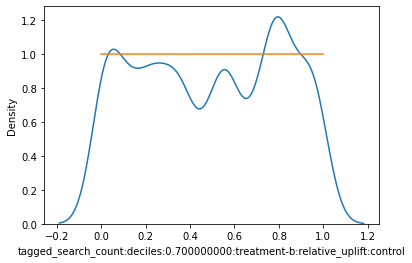

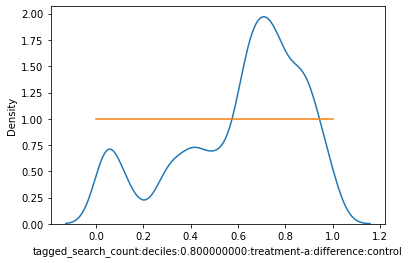

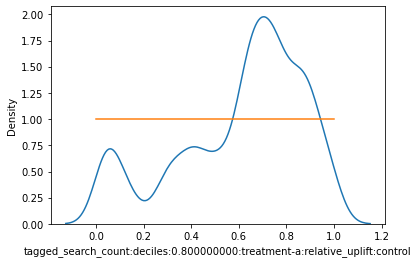

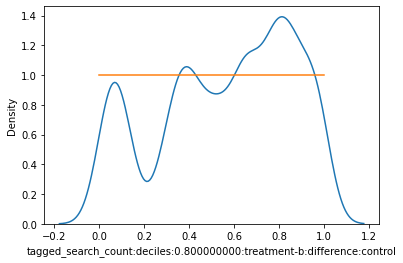

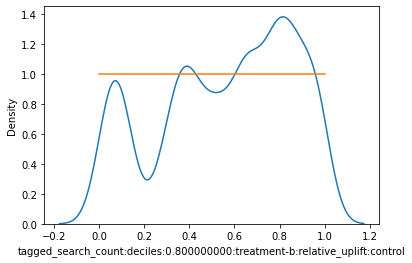

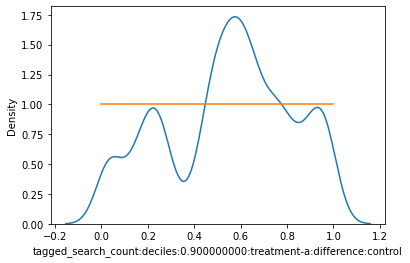

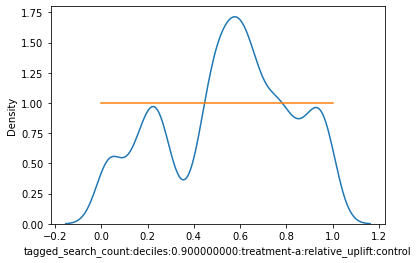

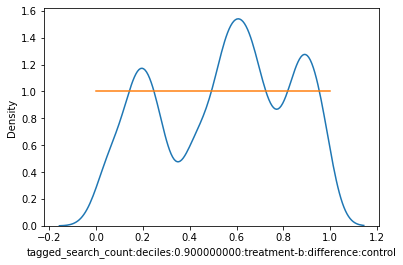

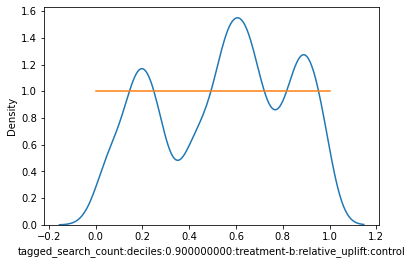

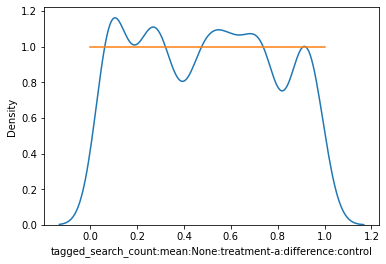

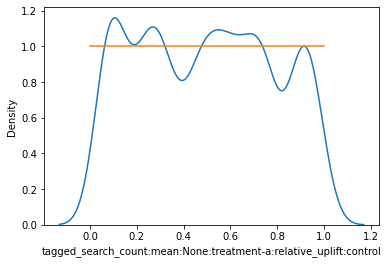

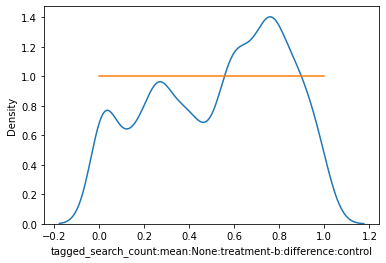

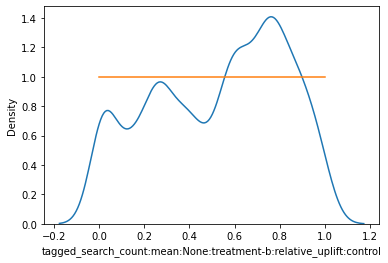

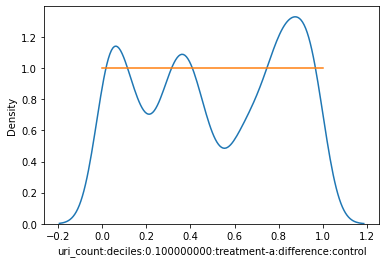

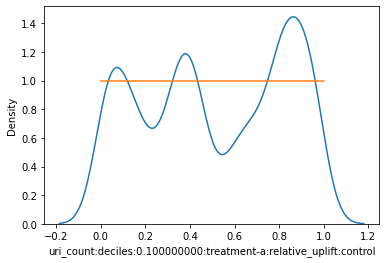

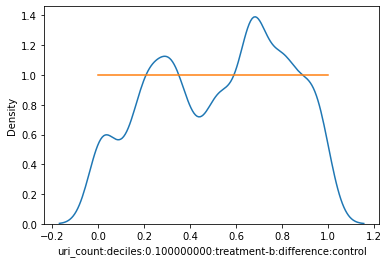

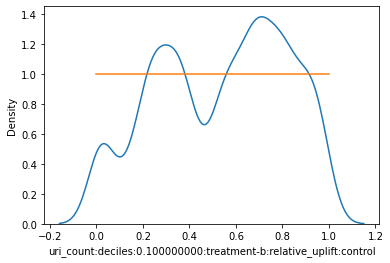

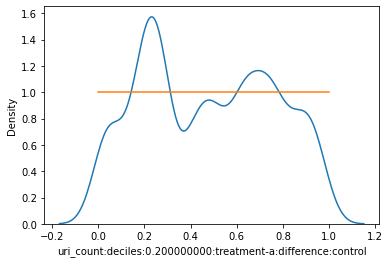

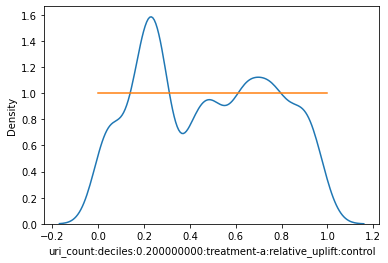

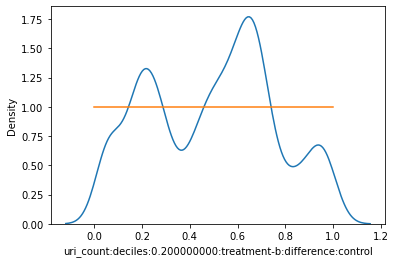

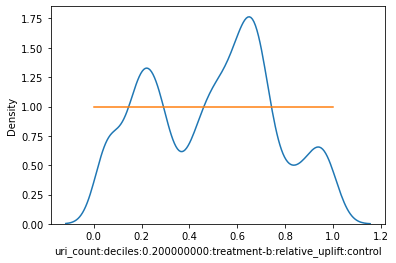

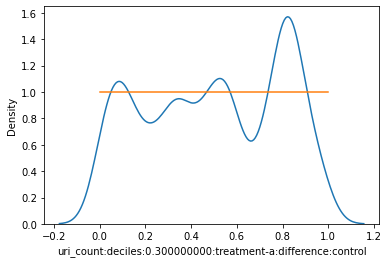

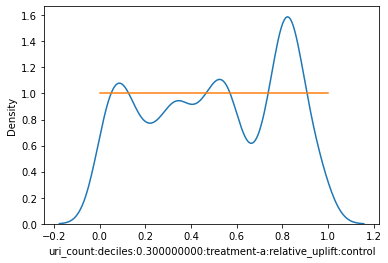

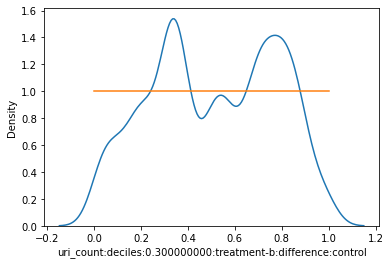

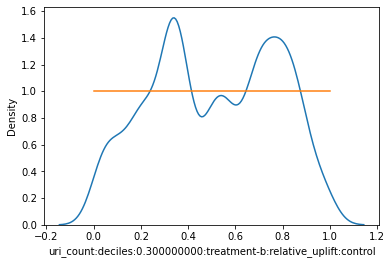

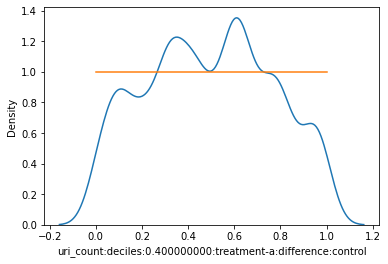

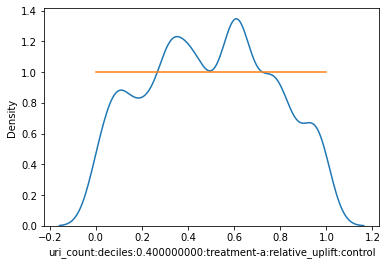

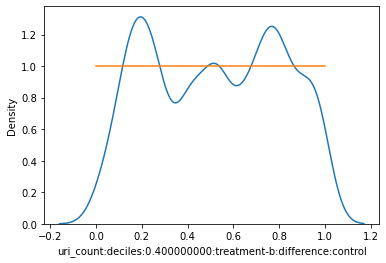

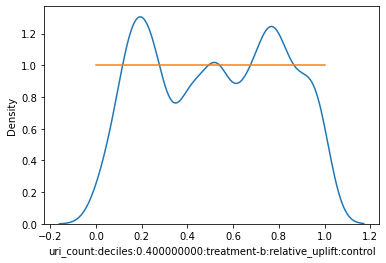

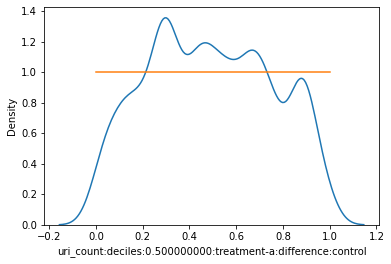

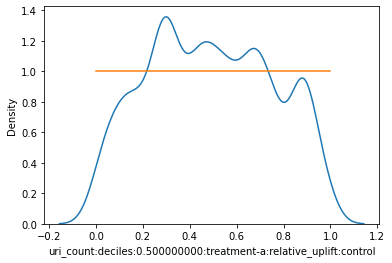

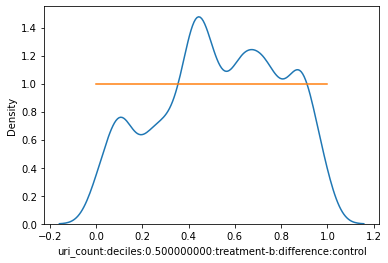

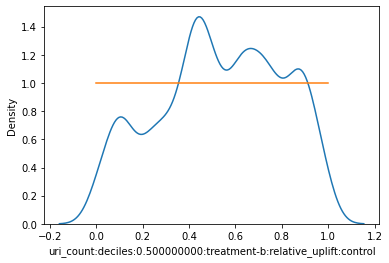

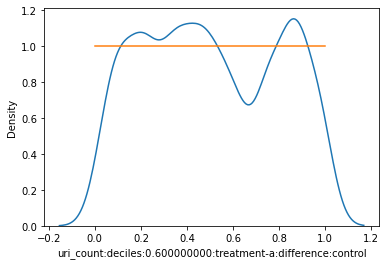

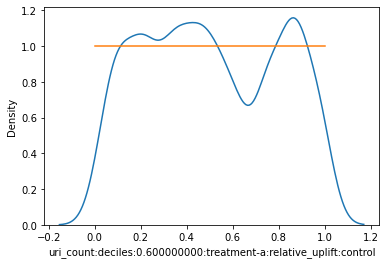

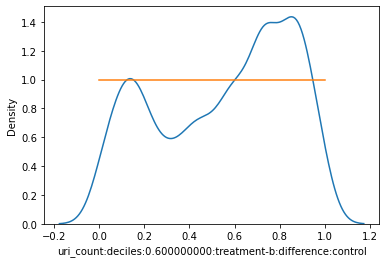

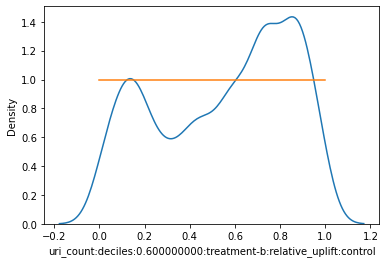

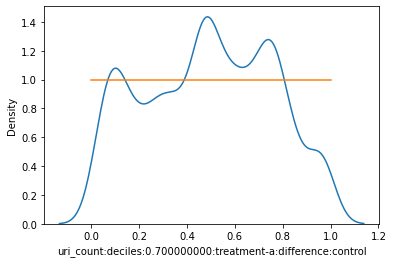

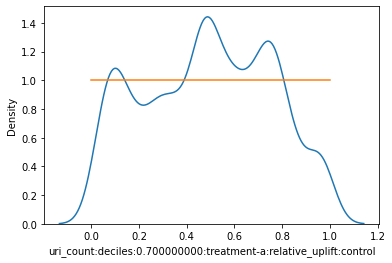

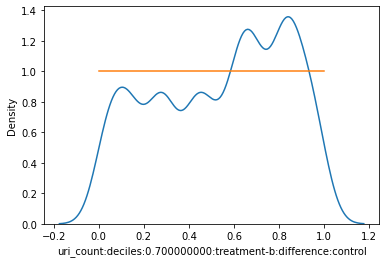

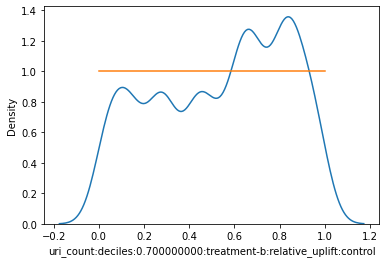

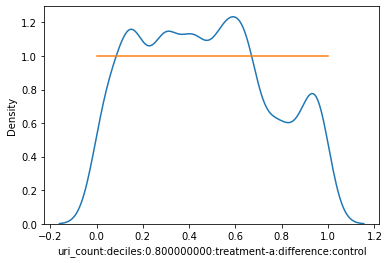

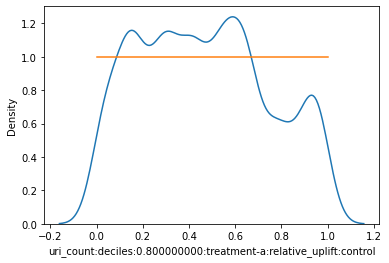

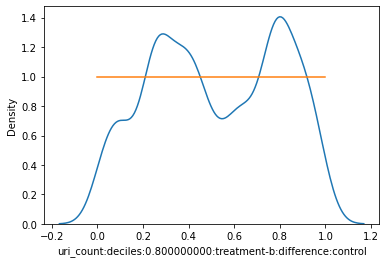

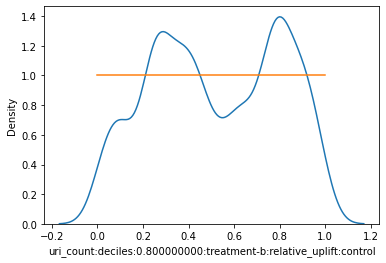

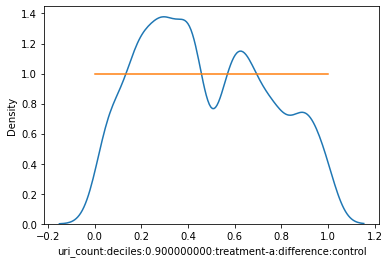

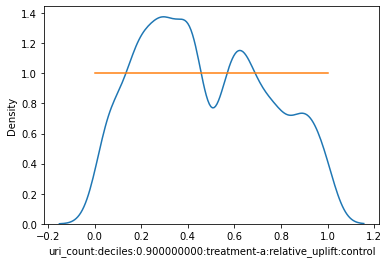

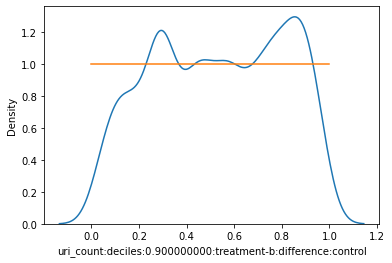

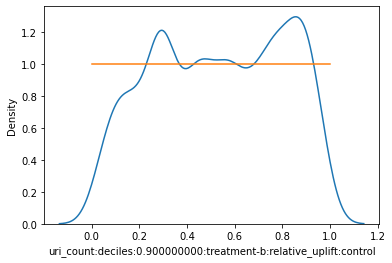

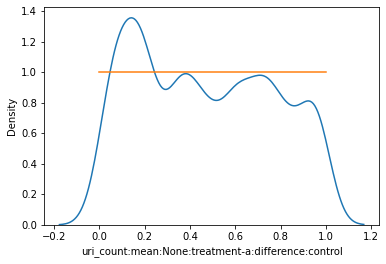

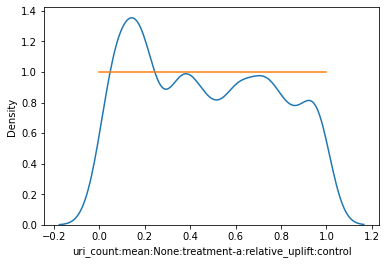

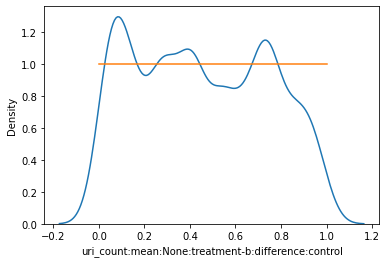

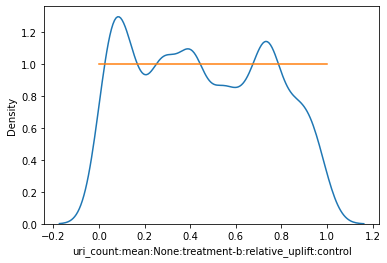

In [18]:
for col in results_no_NAs.columns:
    sns.kdeplot(results_no_NAs[col], bw_adjust=0.5)
    sns.lineplot(x=[0,1],y=[1,1])
    plt.show()

In [15]:
plt.close('all')

# Analysis using CI contains-zero methodology

In [16]:
return ValueError('Work in progress')

SyntaxError: 'return' outside function (2880021171.py, line 1)

In [ ]:
aggregate_df = pd.concat([df[['result_slug', 'sim_number', 'CI_contains_zero']] for df in dfs.values()])

In [ ]:
results_pivot = aggregate_df.pivot(index='sim_number', columns='result_slug')

In [ ]:
results_pivot.columns = results_pivot.columns.droplevel(0)

In [ ]:
prop_sims_with_zero_width_CIs = results_pivot.apply(lambda col: (col == 'Both-zero').mean())

In [ ]:
prop_sims_with_zero_width_CIs[prop_sims_with_zero_width_CIs > 0]

In [ ]:
results_positive_width = results_pivot[prop_sims_with_zero_width_CIs[prop_sims_with_zero_width_CIs == 0].index]

In [ ]:
success_rates = (results_positive_width == 'Yes').mean()
sns.distplot(success_rates)

In [ ]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.01).fit(np.asarray(success_rates).reshape(-1, 1))
X_plot = np.linspace(.75, 1.05, 1000).reshape(-1,1)
dens = np.exp(kde.score_samples(X_plot))

In [ ]:
n_metrics = len(results_positive_width.columns)
null_metric_success_probability = 0.95

In [ ]:
ax = plt.subplots(figsize = (20,10))
sns.lineplot(x=X_plot[:,0], y=dens/dens.sum(), label='Observed')
sns.lineplot(x=np.arange(0,1+1/n_metrics,1/n_metrics), 
             y = binom.pmf(range(n_metrics+1), n_metrics, null_metric_success_probability) * 1/n_metrics, label = 'Theoretical')
plt.xlim((0.7,1.0))
plt.show()